In [43]:
# read data
import pandas as pd

# Okay, I don't know why I named this variable crime...it's supposed to be crash, but my brain short-circuited so
# from now on, let's just pretend that crime is the new, better way to spell crash.
crime = pd.read_csv("../data/curated/crash.csv")

## The distribution of the response variable

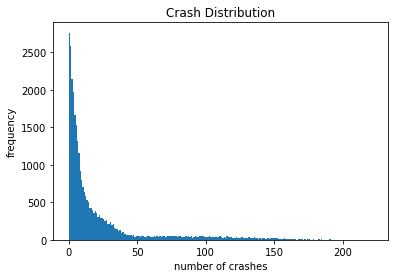

In [60]:
import numpy as np
import matplotlib.pyplot as plt

y = crime["count"]
plt.hist(y, bins=[i for i in range(max(crime["count"]) + 1)])
plt.xlabel("number of crashes")
plt.ylabel("frequency")
plt.title("Crash Distribution")
plt.savefig("../plots/crash_dist.png")

Based on the histogram, the data is not normally distributed. It could be negative binomial or poisson...?

Anyway, the point is, any type of linear model is definitely not applicable here, and I'm not doing negative binomial regression because that is out of the scope of my knowledge.


In [45]:
# apply one hot encoding to transform nominal variable 
# and ordinal encoding to transform ordinal variable
X = crime.drop(columns=["date", "count"])

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer

ohe = OneHotEncoder()
oe = OrdinalEncoder(categories=[["normal", "fast", "empty"]])

ohe.fit_transform(X[["season", "daylight", "borough"]])
oe.fit_transform(X[["speed"]])

X_t = make_column_transformer((ohe, ["season", "daylight", "borough"]), \
    (oe, ["speed"]))

column_names = X_t.fit(X).get_feature_names_out()
X = X_t.fit_transform(X)

print(column_names)
print(X)

['onehotencoder__season_autumn' 'onehotencoder__season_spring'
 'onehotencoder__season_summer' 'onehotencoder__season_winter'
 'onehotencoder__daylight_day' 'onehotencoder__daylight_night'
 'onehotencoder__borough_Bronx' 'onehotencoder__borough_Brooklyn'
 'onehotencoder__borough_Manhattan' 'onehotencoder__borough_Queens'
 'onehotencoder__borough_Staten Island' 'ordinalencoder__speed']
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 1. 2.]
 [0. 0. 0. ... 0. 0. 2.]]


In [46]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Dummy Regression

In [47]:
# simply predicts the value which has the most occurrence, which is 0. This will be used as the baseline.
dummy_pred = np.zeros(y_test.shape[0])

# evaluation using MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(np.sqrt(mean_squared_error(y_test, dummy_pred)))
print(mean_absolute_error(y_test, dummy_pred))

40.64804768437498
21.91822672906916


## Poisson Regression

In [48]:
# note that although the data looks like it follows a poisson distribution,
# its variance is actually a lot larger than its mean. (Poisson has equal mean and variance)

from sklearn.linear_model import PoissonRegressor

pr = PoissonRegressor()
pr.fit(X_train, y_train)
y_pred = pr.predict(X_test)

print(np.mean(y_pred))
print(np.var(y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(mean_absolute_error(y_test, y_pred))

21.865866195876983
553.0199797566553
18.2069078971439
12.273542724483566


In [49]:
# As seen there, although the mean of the predicted values looks fine, 
# the variance of the predicted values are way off the actual variance.
print(np.mean(y_test))
np.var(y_test)
# In addition, the RMSE, although better from the baseline model, is still barely an improvement. 
# The MAE is even worse, possibly because most of the true values are skewed at 0.

21.91822672906916


1171.8551176043402

Since this predicted data has higher variance than mean, the data is overdispersed. Dealing with overdispersion requires a much deeper statistical knowledge that is beyond the scope of my understanding as well as what's required in this subject. (I believe this topic is discussed in MAST30027, but that is in week 4. Given the deadline of this subject, and how much work I have to split among four subjects, I'm afraid that is not possible...not everyone has 150 IQ!)

Instead of doing regression, I will use two models that are both based on decision trees as their main components: random forest and gradient boost. They should, in theory, work better because decision trees don't depend on whether the data follows a certain distribution.

I will also use MAE and MAPE in addition to RMSE as evaluation metrics.

## Random Forest Regression

In [50]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=0)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)


print(np.mean(y_pred))
print(np.var(y_pred))
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(F"MAE  = {mean_absolute_error(y_test, y_pred)}")
rfr_fi = rfr.feature_importances_
rfr_fi

21.903811471109858
1071.3895769712717
RMSE = 10.085603137309388
MAE  = 5.752070297315643


array([0.00512082, 0.00102429, 0.0014735 , 0.01692335, 0.1514377 ,
       0.16466516, 0.05115328, 0.00085469, 0.03746687, 0.00098442,
       0.1657478 , 0.40314812])

## Gradient Boosting Regression

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500, max_depth=10)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

print(np.mean(y_pred))
print(np.var(y_pred))
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(F"MAE  = {mean_absolute_error(y_test, y_pred)}")
gbr_fi = gbr.feature_importances_
gbr_fi

21.905029132628055
1071.556229051951
RMSE = 10.086443240390942
MAE  = 5.752781603307638


array([0.00549205, 0.00063131, 0.00114558, 0.01723692, 0.1739773 ,
       0.14220714, 0.051199  , 0.00064215, 0.03756441, 0.0008402 ,
       0.16592327, 0.40314067])

From the values seen above, the mean and variance of predicted values are very similar, and so are the MAE and RMSE. The feature importance are also similar, and there seem to be a decent gap between the top 4 features compared to the rest.

Hence, I will test that hypothesis by re-doing the modelling to find the ideal number of features.

In [52]:
feature_importance = (rfr_fi + gbr_fi) / 2  # average values between the two models
feature_importance = [float(i) * 100 for i in feature_importance]  # in terms of percentage so that it's easier to see
sorted_fi = sorted(enumerate(feature_importance), key=lambda i: i[1], reverse=True)  # so the original index is kept after sorting
sorted_fi

[(11, 40.314439828757585),
 (10, 16.583553317662624),
 (4, 16.27074980199913),
 (5, 15.343614897082613),
 (6, 5.117613892993555),
 (8, 3.751563950361278),
 (3, 1.7080133576309733),
 (0, 0.530643558516115),
 (2, 0.13095416492123796),
 (9, 0.09123113830717405),
 (1, 0.08278019496963444),
 (7, 0.07484189679807568)]

In [53]:
feature_indices = []
rfr_RMSE = []
rfr_MAE = []
gbr_RMSE = []
gbr_MAE = []

for i in range(len(feature_importance)):
    feature_indices.append(sorted_fi[i][0])
    X_train2 = X_train[:, feature_indices]
    X_test2 = X_test[:, feature_indices]

    # random forest
    rfr.fit(X_train2, y_train)
    y_pred = rfr.predict(X_test2)

    rfr_RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    rfr_MAE.append(mean_absolute_error(y_test, y_pred))

    # gradient boost
    gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500, max_depth=10)
    gbr.fit(X_train2, y_train)
    y_pred = gbr.predict(X_test2)

    gbr_RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    gbr_MAE.append(mean_absolute_error(y_test, y_pred))

In [54]:
print(rfr_RMSE)
print(gbr_RMSE)
print(rfr_MAE)
print(gbr_MAE)

[27.40576813237437, 24.825506468587516, 14.765318977113932, 14.765318977113932, 12.786259417603908, 11.186044004263124, 10.36935252334343, 10.075084780555452, 10.072392047108382, 10.085605225750744, 10.085602532595285, 10.085603041876837]
[27.405766613556892, 24.82544598095163, 14.76495519262043, 14.76495519262043, 12.786242878525146, 11.186032644835105, 10.369127881330538, 10.075159326828478, 10.07272432805397, 10.086443240390942, 10.086443240390942, 10.086443240390942]
[17.07577327149088, 14.346208983428255, 8.055650893959122, 8.055650893959122, 6.982101257076528, 6.401245974654215, 5.95231694574912, 5.775085945686179, 5.758190643249059, 5.75206606726084, 5.752066072897621, 5.752071121434462]
[17.075052915322473, 14.346188768017054, 8.056244931679942, 8.056244931679942, 6.982391613366897, 6.401479789566118, 5.952648588225517, 5.775442183324806, 5.75861195590533, 5.752781603307637, 5.752781603307638, 5.752781603307638]


In [55]:
# in conclusion, all though some features might look insignificant, random forest and gradient boost are 
# robust to overfitting and therefore generally performs better, if not the same, if more features are added in.
# Nevertheless, I will take the top 3 features as the most significanat features. They are:
for i in range(3):
    print(f"column name = {column_names[sorted_fi[i][0]]}")
    print(f"significance = {round(sorted_fi[i][1], 2)}%")
    print("")
    


column name = ordinalencoder__speed
significance = 40.31%

column name = onehotencoder__borough_Staten Island
significance = 16.58%

column name = onehotencoder__daylight_day
significance = 16.27%



In [56]:
# take a look at how features are distributed
import matplotlib.pyplot as plt

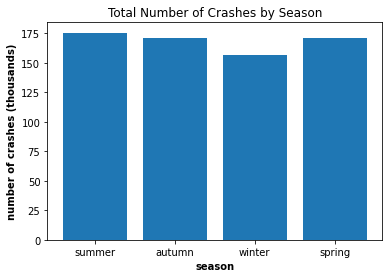

In [119]:
season_count = []
season = ["summer", "autumn", "winter", "spring"]
season_count.append(sum(crime[crime["season"] == "summer"]["count"]) / 1000)
season_count.append(sum(crime[crime["season"] == "autumn"]["count"]) / 1000)
season_count.append(sum(crime[crime["season"] == "winter"]["count"]) / 1000)
season_count.append(sum(crime[crime["season"] == "spring"]["count"]) / 1000)

plt.bar(season, season_count)
plt.ylabel("number of crashes (thousands)", fontweight="bold")
plt.xlabel("season", fontweight="bold")
plt.title("Total Number of Crashes by Season")
plt.savefig("../plots/season_crash.png")

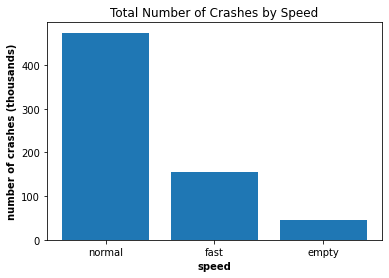

In [116]:
speed_count = []
speed = ["normal", "fast", "empty"]
speed_count.append(sum(crime[crime["speed"] == "normal"]["count"]) / 1000)
speed_count.append(sum(crime[crime["speed"] == "fast"]["count"]) / 1000)
speed_count.append(sum(crime[crime["speed"] == "empty"]["count"]) / 1000)

plt.bar(speed, speed_count)
plt.ylabel("number of crashes (thousands)", fontweight="bold")
plt.xlabel("speed", fontweight="bold")
plt.title("Total Number of Crashes by Speed")
plt.savefig("../plots/speed_crash.png")

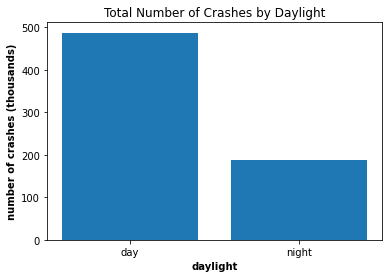

In [117]:
daylight_count = []
daylight = ["day", "night"]
daylight_count.append(sum(crime[crime["daylight"] == "day"]["count"]) / 1000)
daylight_count.append(sum(crime[crime["daylight"] == "night"]["count"]) / 1000)

plt.bar(daylight, daylight_count)
plt.ylabel("number of crashes (thousands)", fontweight="bold")
plt.xlabel("daylight", fontweight="bold")
plt.title("Total Number of Crashes by Daylight")
plt.savefig("../plots/daylight_crash.png")

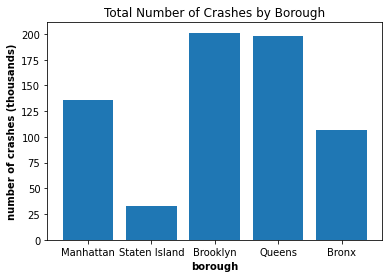

In [118]:
boro_count = []
boro = ["Manhattan", "Staten Island", "Brooklyn", "Queens", "Bronx"]
boro_count.append(sum(crime[crime["borough"] == "Manhattan"]["count"]) / 1000)
boro_count.append(sum(crime[crime["borough"] == "Staten Island"]["count"]) / 1000)
boro_count.append(sum(crime[crime["borough"] == "Brooklyn"]["count"]) / 1000)
boro_count.append(sum(crime[crime["borough"] == "Queens"]["count"]) / 1000)
boro_count.append(sum(crime[crime["borough"] == "Bronx"]["count"]) / 1000)

plt.bar(boro, boro_count)
plt.ylabel("number of crashes (thousands)", fontweight="bold")
plt.xlabel("borough", fontweight="bold")
plt.title("Total Number of Crashes by Borough")
plt.savefig("../plots/boro_crash.png")

In [115]:
# Both models perform very similarly, so it doesn't matter which one to choose
# (I'm choosing GBR in this case)
pred_df = pd.DataFrame(X_test, columns=column_names)
pred_df["pred_count"] = np.rint(y_pred)
# find the top 10 predicted values
pred_df.sort_values(by="pred_count", ascending=False).drop_duplicates().head(10)

,onehotencoder__season_autumn,onehotencoder__season_spring,onehotencoder__season_summer,onehotencoder__season_winter,onehotencoder__daylight_day,onehotencoder__daylight_night,onehotencoder__borough_Bronx,onehotencoder__borough_Brooklyn,onehotencoder__borough_Manhattan,onehotencoder__borough_Queens,onehotencoder__borough_Staten Island,ordinalencoder__speed,pred_count
2472,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,137.0
7361,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,130.0
2046,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,129.0
3345,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,125.0
6825,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,119.0
4511,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,111.0
4231,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,97.0
165,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,96.0
3530,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,92.0
3482,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,85.0
